# Combine Face Detection With Emotion Detection

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import cv2
import zipfile
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Define Emotion Detection Network

In [2]:
class EmotionDetectionModel2(nn.Module):
    
    def __init__(self, img_size):
        super(EmotionDetectionModel2, self).__init__()

        self._num_classes = 7
        self._img_channels = 1
        self.dropout_factor1 = 0.2
        self.dropout_factor2 = 0.4

        # input to BatchNorm2d is the amount of filters
        
        # First convolution block -----
        self.conv1 = nn.Conv2d(in_channels=self._img_channels, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.4)
        
        
        # Second convolution block -----
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)
        
        
        # Third convolution block -----
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.5)


        # Fully connected layers
        
        # Calculate the output size of the feature maps after the convolutional layers
        self.flatten_size = self._calculate_conv_output_size(img_size)

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.6)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, self._num_classes)

    
    def _calculate_conv_output_size(self, img_size):
        # Helper method to compute the spatial dimensions after the convolution and pooling layers
        size = img_size // 8  # Since 3 pooling layers, we reduce the size by a factor of 8
        return size * size * 256  # 256 filters at the final conv layer

    
    def save_model(self, train_losses, train_accs, val_losses, val_accs):
        # Get the current date and time
        date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

        # Save the model state and training history
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": val_losses,
                "val_accs": val_accs,
            },
            f"./EmotionDetectionModel-{date_and_time}.ckpt",  # Use f-string for formatting
        )
        
    
    def forward(self, x):
        
        # First convolution block -----
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolution block -----
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolution block -----
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

### Load Trained Instance of Emotion Detection Model

In [13]:
# third model, uses EmotionDetectionModel2 but with a lower batch size 
# Load the model checkpoint, specifying that you want to load it on the CPU
emotion_model = torch.load("third_model.ckpt", map_location=torch.device('cpu'))

# Instantiate the model
emotion_model = EmotionDetectionModel2(48)

# Load the state dictionary into the model
emotion_model.load_state_dict(third_model_loaded["model_state_dict"])

# Define emotion labels as a dictionary
emotion_labels_dict = {
    0: "angry",
    1: "disgusted",
    2: "fearful",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprised"
}
emotion_model.eval()  # Set to evaluation mode (important)


EmotionDetectionModel2(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), 

### Load Trained Face Detection Model

In [8]:
face_model = YOLO('../object-detection/runs/detect/train7/weights/best.pt')  # Replace with the path to your trained face detection model

### Define Function That Extracts Emotions On Faces 

In [9]:
def detect_faces_and_predict_emotions(image_path, face_model, emotion_model, img_size=48):
    # Step 1: Run Face Detection on the Image
    face_results = face_model.predict(source=image_path, save=False, show=False)

    # Load the original image using OpenCV
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Initialize a list to store cropped faces and corresponding emotions
    faces_and_emotions = []

    # Step 2: Iterate through the bounding boxes from face detection
    for result in face_results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)  # Get coordinates and convert to integer

            # Crop the face from the original image
            cropped_face = image_rgb[y1:y2, x1:x2]

            # Resize the cropped face to match the input size of the emotion model
            cropped_face_resized = cv2.resize(cropped_face, (img_size, img_size))
            cropped_face_gray = cv2.cvtColor(cropped_face_resized, cv2.COLOR_RGB2GRAY)
            cropped_face_tensor = torch.tensor(cropped_face_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0  # Shape: [1, 1, 48, 48]

            # Step 3: Run the cropped face through the emotion detection model
            with torch.no_grad():  # Disable gradient calculation for inference
                emotion_prediction = emotion_model(cropped_face_tensor)
                emotion_index = torch.argmax(emotion_prediction).item()
                emotion_label = emotion_labels_dict[emotion_index]

            # Save the cropped face and the predicted emotion label
            faces_and_emotions.append((cropped_face, emotion_label))

    # Step 4: Plot Each Cropped Face with Its Predicted Emotion
    if len(faces_and_emotions) > 0:
        num_faces = len(faces_and_emotions)
        fig, axs = plt.subplots(1, num_faces, figsize=(15, 5))

        # If there's only one face, wrap axs in a list for consistency
        if num_faces == 1:
            axs = [axs]

        for idx, (face, emotion) in enumerate(faces_and_emotions):
            axs[idx].imshow(face)
            axs[idx].axis('off')
            axs[idx].set_title(emotion)

        plt.tight_layout()
        plt.show()
    else:
        print("No faces detected in the image.")

### Try Function On Random Test Images

Randomly selected image: ../object-detection/Test/images/6_Funeral_Funeral_6_265.jpg

image 1/1 C:\Users\Alfred Aronsson\SSY340-Project\FinalProduct\..\object-detection\Test\images\6_Funeral_Funeral_6_265.jpg: 512x640 11 faces, 154.2ms
Speed: 3.0ms preprocess, 154.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


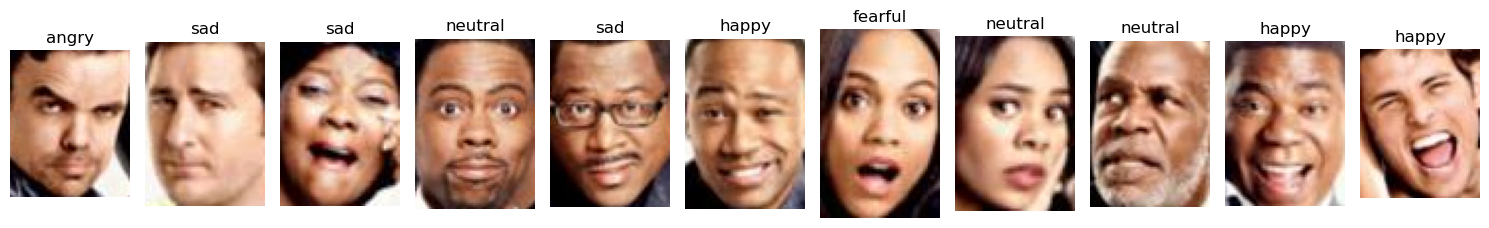

In [26]:
# Define the path to the images directory
images_dir = '../object-detection/Test/images/'

# List all image files in the directory (directly under images_dir)
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Ensure there are images available
if len(image_files) == 0:
    print("No images found in the directory.")
else:
    # Randomly select an image from the list
    image_path = random.choice(image_files)
    print(f"Randomly selected image: {image_path}")

    # Call the function to detect faces and predict emotions
    detect_faces_and_predict_emotions(image_path, face_model, emotion_model)